In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/Shared drives/Optimization in Machine Learning/image')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/Shared drives/Optimization in Machine Learning/image
29910.jpg	     nyc-world-trade-center-skyline-xl.jpg  Taj_Gogh.png
800px-Taj-Mahal.jpg  Tag_Gogh.png


In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch
import numpy as np
import pprint
import torch.optim as optim
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torchvision.transforms.functional as TF
from torchvision import transforms

In [ ]:
! wget https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Taj-Mahal.jpg/800px-Taj-Mahal.jpg

--2020-03-21 05:40:40--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Taj-Mahal.jpg/800px-Taj-Mahal.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107445 (105K) [image/jpeg]
Saving to: ‘800px-Taj-Mahal.jpg’

800px-Taj-Mahal.jpg 100%[===================>] 104.93K  --.-KB/s    in 0.002s  

2020-03-21 05:40:41 (46.1 MB/s) - ‘800px-Taj-Mahal.jpg’ saved [107445/107445]



(512, 512, 3)


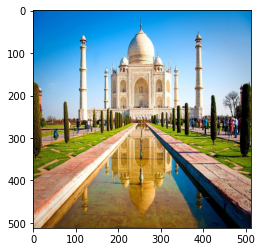

In [ ]:
import cv2
img = cv2.imread('./800px-Taj-Mahal.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
contentImage = torch.tensor(img/255).float().cuda()

In [ ]:
content_mean = contentImage.view(contentImage.shape[0], -1).mean(dim=1)
content_std = contentImage.view(contentImage.shape[0], -1).std(dim=1)

content_normalizer = transforms.Normalize(mean=content_mean, std=content_std)
content_tensor = content_normalizer(contentImage)

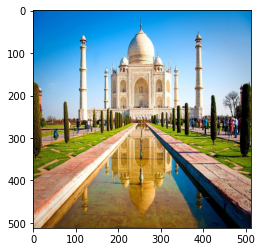

In [ ]:
plt.imshow(contentImage.cpu().data)

In [ ]:
# download style image (change the style images!)
! wget https://wallpaperplay.com/walls/full/9/9/d/29910.jpg

--2020-03-21 05:40:56--  https://wallpaperplay.com/walls/full/9/9/d/29910.jpg
Resolving wallpaperplay.com (wallpaperplay.com)... 206.189.62.118
Connecting to wallpaperplay.com (wallpaperplay.com)|206.189.62.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2164735 (2.1M) [image/jpeg]
Saving to: ‘29910.jpg’

29910.jpg           100%[===================>]   2.06M  1.19MB/s    in 1.7s    

2020-03-21 05:40:59 (1.19 MB/s) - ‘29910.jpg’ saved [2164735/2164735]



(512, 512, 3)


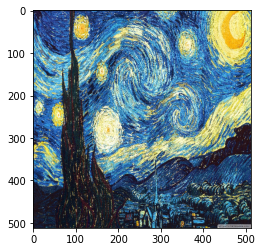

In [ ]:
import cv2
img = cv2.imread('./29910.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
styleImage = torch.tensor(img/255.0).float().cuda()

In [ ]:
style_mean = styleImage.view(styleImage.shape[0], -1).mean(dim=1)
style_std = styleImage.view(styleImage.shape[0], -1).std(dim=1)

style_normalizer = transforms.Normalize(mean=style_mean, std=style_std)
style_tensor = style_normalizer(styleImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


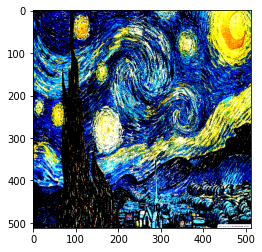

In [ ]:
plt.imshow(style_tensor.cpu().data)

In [ ]:
import torchvision.models as models
model = models.vgg19(pretrained=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# Converting MaxPool layers to AvgPool layers
for i, layer in enumerate(model.features):
  if isinstance(layer, torch.nn.MaxPool2d):
    model.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [ ]:
# Don't need to train vgg model
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
# We care about the first part of the model (model.features)
layers = []
for idx, m in enumerate(model.features.modules()):
    if idx > 0:
      m.requires_grad = False
      print(idx, '->', m)
      layers.append([m,isinstance(m, torch.nn.Conv2d)])  # we will store all the layers into list for later usage

1 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 -> ReLU(inplace=True)
3 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 -> ReLU(inplace=True)
5 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
6 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 -> ReLU(inplace=True)
8 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 -> ReLU(inplace=True)
10 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
11 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 -> ReLU(inplace=True)
13 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 -> ReLU(inplace=True)
15 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 -> ReLU(inplace=True)
17 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU(inplace=True)
19 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
20 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
layers_ReLU  = []
for idx, m in enumerate(model.features.modules()):
    if idx > 0:
      m.requires_grad = False
      print(idx, '->', m)
      layers_ReLU.append([m,isinstance(m, torch.nn.ReLU)])

1 -> Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 -> ReLU(inplace=True)
3 -> Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 -> ReLU(inplace=True)
5 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
6 -> Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 -> ReLU(inplace=True)
8 -> Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 -> ReLU(inplace=True)
10 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
11 -> Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 -> ReLU(inplace=True)
13 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 -> ReLU(inplace=True)
15 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 -> ReLU(inplace=True)
17 -> Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 -> ReLU(inplace=True)
19 -> AvgPool2d(kernel_size=2, stride=2, padding=0)
20 -> Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
layers_ReLU

[[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [AvgPool2d(kernel_size=2, stride=2, padding=0), False],
 [Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [AvgPool2d(kernel_size=2, stride=2, padding=0), False],
 [Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), False],
 [ReLU(inplace=True), True],
 [AvgPool2d(kernel_size=2, s

In [ ]:
# Content Image Convolutions
imgInput = torch.transpose(contentImage.unsqueeze(0),1,3)
aCs=[]
for l,isConv in layers_ReLU:
  imgInput = l(imgInput)
  if isConv:
    aCs.append(imgInput)
    print ("shape of this is",imgInput.shape)

shape of this is torch.Size([1, 64, 512, 512])
shape of this is torch.Size([1, 64, 512, 512])
shape of this is torch.Size([1, 128, 256, 256])
shape of this is torch.Size([1, 128, 256, 256])
shape of this is torch.Size([1, 256, 128, 128])
shape of this is torch.Size([1, 256, 128, 128])
shape of this is torch.Size([1, 256, 128, 128])
shape of this is torch.Size([1, 256, 128, 128])
shape of this is torch.Size([1, 512, 64, 64])
shape of this is torch.Size([1, 512, 64, 64])
shape of this is torch.Size([1, 512, 64, 64])
shape of this is torch.Size([1, 512, 64, 64])
shape of this is torch.Size([1, 512, 32, 32])
shape of this is torch.Size([1, 512, 32, 32])
shape of this is torch.Size([1, 512, 32, 32])
shape of this is torch.Size([1, 512, 32, 32])


In [ ]:
# Style Image Convolutions
styleinput = torch.transpose(styleImage.unsqueeze(0),1,3)
aSs = [] 
for l, isConv in layers_ReLU:
  styleinput = l(styleinput)
  if isConv:
    aSs.append(styleinput)

In [ ]:
# GRADED FUNCTION: compute_content_cost
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # for i in range(w):
    #   n = 4*a_C[i].view(-1).shape[0]
    #   J_content += (torch.norm(a_C[i].view(a_C[i].shape[1],-1)-a_G[i].view(a_G[i].shape[1],-1)**2))/n
    # return J_content
    n = 4*a_C.view(-1).shape[0]
    J_content = (torch.norm(a_C.view(a_C.shape[1],-1)-a_G.view(a_G.shape[1],-1)**2))/n
    return J_content

In [ ]:
# gram_matrix
# i = 5 #number of layer
# Take A as the convolution layer input 
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    # Gram matrix for convolution layers 
    layer_matrix = A.view(A.shape[1],-1)
    grammatrix = torch.mm(layer_matrix, torch.transpose(layer_matrix, 0, 1))    
    return grammatrix

In [ ]:
# compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_C, n_H, n_W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    stylegram = gram_matrix(a_S)
    generatedgram = gram_matrix(a_G)
    n = ((a_S.view(-1).shape[0])**2)*4
    J_style_layer = (torch.norm(stylegram - generatedgram)**2)/n
    
    return J_style_layer

In [ ]:
STYLE_LAYERS_WEIGHTS = [0 for i in range(16)]

for i in range(12):
  STYLE_LAYERS_WEIGHTS[i] = 1/(16*15)
  STYLE_LAYERS_WEIGHTS[12] = 15/16
  if i==11:
    STYLE_LAYERS_WEIGHTS[i+2] = 1/(16*15)
    STYLE_LAYERS_WEIGHTS[i+3] = 1/(16*15)
    STYLE_LAYERS_WEIGHTS[i+4] = 1/(16*15)
print(STYLE_LAYERS_WEIGHTS[12])
print(sum(STYLE_LAYERS_WEIGHTS))

0.9375
1.0


In [ ]:
def compute_style_cost(a_S, a_G, STYLE_LAYERS_WEIGHTS, layer):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    aGs, aSc -- activations after conv2d for G ans S images
    STYLE_LAYERS -- A python list containing a coefficient for each cost layer
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above
    """
    
    # initialize the overall style cost
    J_style = 0
    

    for i in range(layer):
      stylegram = gram_matrix(a_S[i])
      generatedgram = gram_matrix(a_G[i])
      n = ((a_S[i].view(-1).shape[0])**2)*4    
      J_style += STYLE_LAYERS_WEIGHTS[i]*(torch.norm(stylegram - generatedgram)**2)/n    

    return J_style

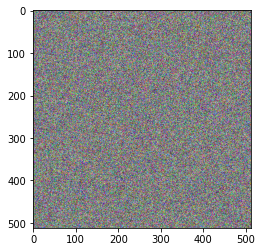

In [ ]:
G = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G.cpu().data)
plt.show()
loss_history=[]

In [ ]:
def closure():
  optimizer.zero_grad()
  content_loss = compute_content_cost(aCs[i], aGs[i])
  style_loss = compute_style_cost(aSs, aGs, STYLE_LAYERS_WEIGHTS, 12)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  return total_loss

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G],lr=1e-2)
#optimizer = optim.LBFGS([G],lr=1e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[700], gamma=0.1)


alpha = 1e4
beta = 1e3
total_loss_list = []
epochs = 1000
i = 5
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final = torch.transpose(G.unsqueeze(0),1,3)
  aGs=[]
  for l,isConv in layers:
    imgInput_final = l(imgInput_final)
    if isConv:
      aGs.append(imgInput_final) 
  content_loss = compute_content_cost(aCs[i], aGs[i])
  style_loss = compute_style_cost(aSs, aGs, STYLE_LAYERS_WEIGHTS, 12)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 4.526501
Loss at 100 iteration is 0.992484
Loss at 200 iteration is 0.834425
Loss at 300 iteration is 0.781036
Loss at 400 iteration is 0.753732
Loss at 500 iteration is 0.736464
Loss at 600 iteration is 0.723940
Loss at 700 iteration is 0.713549
Loss at 800 iteration is 0.705456
Loss at 900 iteration is 0.699018


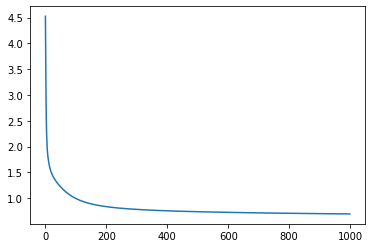

In [ ]:
plt.plot(total_loss_list)
loss_history.append(total_loss_list[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


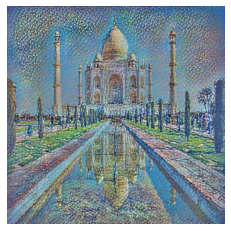

In [ ]:
#plt.imshow(G.cpu().data)fig = plt.figure()
plt.imshow(G.cpu().data)
plt.axis('off')
plt.savefig('./Tag_Gogh.png')

 **Using alpha = 1e3 and beta = 1e1 for first 1000 iterations to get content right. The beta is then increasing beta to 1e6 or 1e7 with decaying learning rate for more 2000-3000 iterations**

In [ ]:
STYLE_LAYERS_WEIGHTS_1 = [0 for i in range(16)]

for i in range(5):
  STYLE_LAYERS_WEIGHTS_1[i] = 1/5
print(STYLE_LAYERS_WEIGHTS_1)
print(sum(STYLE_LAYERS_WEIGHTS_1))

[0.2, 0.2, 0.2, 0.2, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1.0


In [ ]:
style_mean = styleImage.view(styleImage.shape[0], -1).mean(dim=1)
style_std = styleImage.view(styleImage.shape[0], -1).std(dim=1)

style_normalizer = transforms.Normalize(mean=style_mean, std=style_std)
style_tensor = style_normalizer(styleImage)

In [ ]:
# Style Image Convolutions
styleinput = torch.transpose(style_tensor.unsqueeze(0),1,3)
aSs = [] 
for l, isConv in layers:
  styleinput = l(styleinput)
  if isConv:
    aSs.append(styleinput)

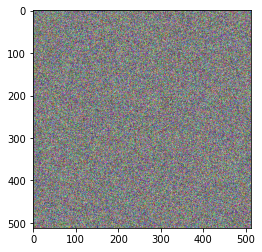

In [ ]:
G1 = torch.rand(contentImage.shape, requires_grad=True, device="cuda")
plt.imshow(G1.cpu().data)
plt.show()

loss_history_1=[]

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G1],lr=1e-5)
#optimizer = optim.LBFGS([G],lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,250,300,350,400,450], gamma=0.1)


alpha = 1e3
beta = 1e7
total_loss_list_1 = []
epochs = 1000
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_1 = torch.transpose(G1.unsqueeze(0),1,3)
  aG1s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_1 = l(imgInput_final_1)
    if isConv:
      aG1s.append(imgInput_final_1) 
  content_loss = compute_content_cost(aCs[i], aG1s[i])
  style_loss = compute_style_cost(aSs, aG1s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 2480600.500000
Loss at 100 iteration is 2472862.750000
Loss at 200 iteration is 2465109.250000
Loss at 300 iteration is 2457337.500000
Loss at 400 iteration is 2449548.750000
Loss at 500 iteration is 2441745.750000
Loss at 600 iteration is 2433927.500000
Loss at 700 iteration is 2426094.500000
Loss at 800 iteration is 2418249.750000
Loss at 900 iteration is 2410393.500000


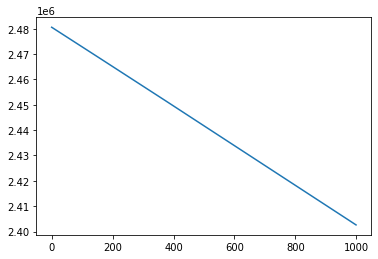

In [ ]:
plt.plot(total_loss_list_1)
loss_history_1.append(total_loss_list_1[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


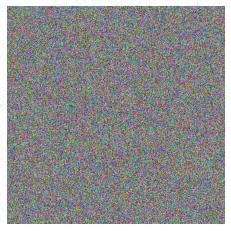

In [ ]:
plt.imshow(G1.cpu().data)
plt.axis('off')
plt.savefig('./Taj_Gogh.png')

Third Trial

Using transformed input images with style weights at 12th layer and 1-4 layers. The values of alpha and beta at 10 and 10^4. Paper recommends the alpha/beta ratio to be 10^-3  or 10^-4

Alpha and beta changes to 10^4 and 10^3 respectively. As no content observed with previous weights

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
! wget https://drive.google.com/file/d/1gGkjbCgHUFKHia43fVtc9_mqpw1T4XOa/view?usp=sharing

--2020-03-17 20:43:06--  https://drive.google.com/file/d/1gGkjbCgHUFKHia43fVtc9_mqpw1T4XOa/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 172.217.194.102, 172.217.194.101, 172.217.194.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  67.72K  --.-KB/s    in 0.1s    

2020-03-17 20:43:06 (466 KB/s) - ‘view?usp=sharing’ saved [69347]



(512, 512, 3)


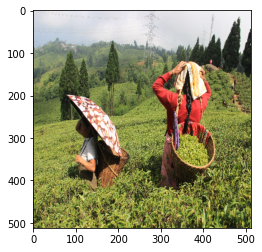

In [ ]:
import cv2
img = cv2.imread('./IMG_0079.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
contentImage1 = torch.tensor(img/255).float().cuda()

In [ ]:
content_mean = contentImage1.view(contentImage1.shape[0], -1).mean(dim=1)
content_std = contentImage1.view(contentImage1.shape[0], -1).std(dim=1)

content_normalizer = transforms.Normalize(mean=content_mean, std=content_std)
content_tensor = content_normalizer(contentImage1)

In [ ]:
! wget https://en.wikipedia.org/wiki/American_Gothic#/media/File:Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg

--2020-03-17 21:06:36--  https://en.wikipedia.org/wiki/American_Gothic
Resolving en.wikipedia.org (en.wikipedia.org)... 208.80.154.224, 2001:df2:e500:ed1a::1
Connecting to en.wikipedia.org (en.wikipedia.org)|208.80.154.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93202 (91K) [text/html]
Saving to: ‘American_Gothic’

American_Gothic     100%[===================>]  91.02K   162KB/s    in 0.6s    

2020-03-17 21:06:38 (162 KB/s) - ‘American_Gothic’ saved [93202/93202]



In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving Wheat-Field-with-Cypresses-(1889)-Vincent-van-Gogh-Met.jpg to Wheat-Field-with-Cypresses-(1889)-Vincent-van-Gogh-Met.jpg


(512, 512, 3)


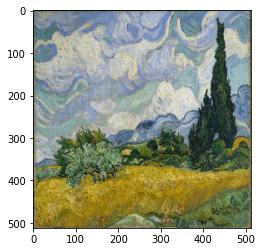

In [ ]:
import cv2
img = cv2.imread('./Wheat-Field-with-Cypresses-(1889)-Vincent-van-Gogh-Met.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
styleImage1 = torch.tensor(img/255.0).float().cuda()

In [ ]:
style_mean = styleImage1.view(styleImage1.shape[0], -1).mean(dim=1)
style_std = styleImage1.view(styleImage1.shape[0], -1).std(dim=1)

style_normalizer = transforms.Normalize(mean=style_mean, std=style_std)
style_tensor = style_normalizer(styleImage1)

In [ ]:
# Content Image Convolutions
imgInput1 = torch.transpose(contentImage1.unsqueeze(0),1,3)
aCs1=[]
for l,isConv in layers_ReLU:
  imgInput1 = l(imgInput1)
  if isConv:
    aCs1.append(imgInput1)
    #print ("shape of this is",imgInput.shape)

In [ ]:
# Style Image Convolutions
styleinput1 = torch.transpose(styleImage1.unsqueeze(0),1,3)
aSs1 = [] 
for l, isConv in layers_ReLU:
  styleinput1 = l(styleinput1)
  if isConv:
    aSs1.append(styleinput1)

In [ ]:
STYLE_LAYERS_WEIGHTS_2 = [0 for i in range(16)]
for i in range(5):
  STYLE_LAYERS_WEIGHTS_2[i] = 0.2/5
STYLE_LAYERS_WEIGHTS_2[12] = 0.8
print(STYLE_LAYERS_WEIGHTS_2)
print(sum(STYLE_LAYERS_WEIGHTS_2))

[0.04, 0.04, 0.04, 0.04, 0.04, 0, 0, 0, 0, 0, 0, 0, 0.8, 0, 0, 0]
1.0


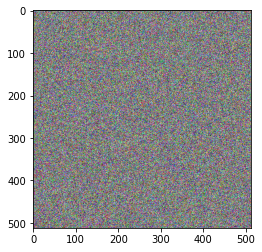

In [ ]:
G2 = torch.rand(contentImage1.shape, requires_grad=True, device="cuda")
plt.imshow(G2.cpu().data)
plt.show()

**Initializing the alpha and beta values at 1e3 and 1e1 respectively. Running Adam for 1000 iterations with lr 1e-2**

**Increasing beta to 1e5 for 2000 more iterations with decay at 0.1 and lr at 1e-3**

**Testing with a decrease in aplha to 1e1 and same beta to test.**

**Increasing the value of beta to 1e6 and decreasing the lr to 1e-4 and decay of 0.1**

In [ ]:
milestones = [i*500 for i in range(2)]
print(milestones)

[0, 500]


In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G2],lr=1e-4)
#optimizer = optim.LBFGS([G],lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)


alpha = 1e1
beta = 1e6
total_loss_list_1 = []
epochs = 1000
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_1 = torch.transpose(G2.unsqueeze(0),1,3)
  aG2s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_1 = l(imgInput_final_1)
    if isConv:
      aG2s.append(imgInput_final_1) 
  content_loss = compute_content_cost(aCs1[i], aG2s[i])
  style_loss = compute_style_cost(aSs1, aG2s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 0.060377
Loss at 100 iteration is 0.059305
Loss at 200 iteration is 0.057932
Loss at 300 iteration is 0.056263
Loss at 400 iteration is 0.054420
Loss at 500 iteration is 0.052521
Loss at 600 iteration is 0.052322
Loss at 700 iteration is 0.052103
Loss at 800 iteration is 0.051867
Loss at 900 iteration is 0.051614


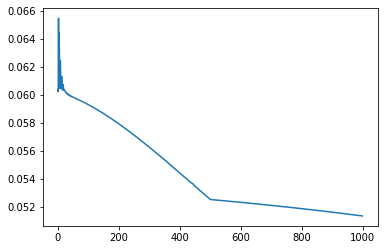

In [ ]:
plt.plot(total_loss_list_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


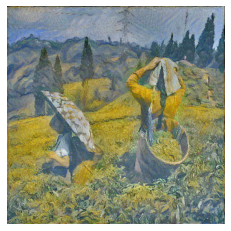

In [ ]:
fig = plt.figure()
plt.imshow(G2.cpu().data)
plt.axis('off')
fig.savefig('./NE_Gogh.png')

**Alpha = 1e1 and Beta = 1e0 and lr at 1e-2 for 1000 iterations**

**Decaying the rate by 0.1 fro next 1000 iterations. Same weights**

**Changing beta to 1e2 for 1000 iterations**

**Changing learning rate to 1e-4. Same weights**

**Running for 1000 more iterations**

**Changing beta to 1e3. Good Results observed**

**Changing alpha to 1e2 and beta to 1e0 to possibly bring more content**

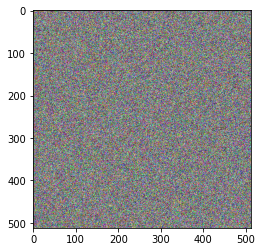

In [ ]:
G3 = torch.rand(contentImage1.shape, requires_grad=True, device="cuda")
plt.imshow(G3.cpu().data)
plt.show()

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G3],lr=1e-4)
#optimizer = optim.LBFGS([G],lr=1e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[700], gamma=0.1)


alpha = 1e2
beta = 1e0
total_loss_list_1 = []
epochs = 1000
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_1 = torch.transpose(G3.unsqueeze(0),1,3)
  aG3s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_1 = l(imgInput_final_1)
    if isConv:
      aG3s.append(imgInput_final_1) 
  content_loss = compute_content_cost(aCs1[i], aG3s[i])
  style_loss = compute_style_cost(aSs, aG3s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 0.016247
Loss at 100 iteration is 0.013708
Loss at 200 iteration is 0.011892
Loss at 300 iteration is 0.010609
Loss at 400 iteration is 0.009697
Loss at 500 iteration is 0.009040
Loss at 600 iteration is 0.008556
Loss at 700 iteration is 0.008191
Loss at 800 iteration is 0.007907
Loss at 900 iteration is 0.007681


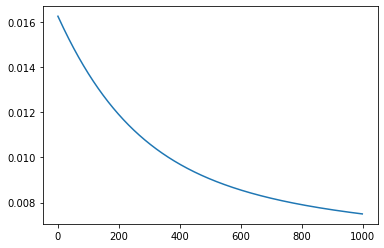

In [ ]:
plt.plot(total_loss_list_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


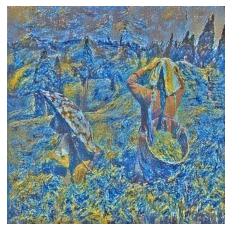

In [ ]:
fig = plt.figure()
plt.imshow(G3.cpu().data)
plt.axis('off')
fig.savefig('./NE_Stary.png')

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving IMG_1368.JPG to IMG_1368.JPG


(512, 512, 3)


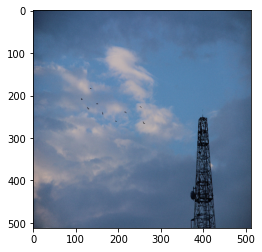

In [ ]:
import cv2
img = cv2.imread('./IMG_9873.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
contentImage2 = torch.tensor(img/255).float().cuda()

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving Sunday.jpg to Sunday.jpg


(512, 512, 3)


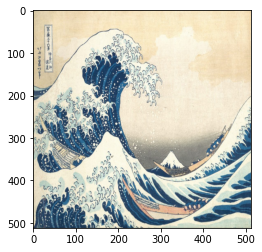

In [ ]:
import cv2
img = cv2.imread('./Wave.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
styleImage2 = torch.tensor(img/255.0).float().cuda()

In [ ]:
# Content Image Convolutions
imgInput2 = torch.transpose(contentImage2.unsqueeze(0),1,3)
aCs3=[]
for l,isConv in layers_ReLU:
  imgInput2 = l(imgInput2)
  if isConv:
    aCs3.append(imgInput2)

# Style Image Convolutions
styleinput2 = torch.transpose(styleImage2.unsqueeze(0),1,3)
aSs3 = [] 
for l, isConv in layers_ReLU:
  styleinput2 = l(styleinput2)
  if isConv:
    aSs3.append(styleinput2)

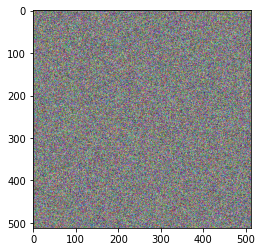

In [ ]:
G4 = torch.rand(contentImage2.shape, requires_grad=True, device="cuda")
plt.imshow(G4.cpu().data)
plt.show()

**Initialize alpha and beta to 1e3 and 1e0 and lr at 1e-2 for initial 1000 iterations**

**Changing beta to 1e3 and run for 1000 iterations**

**Decay by 0.1 and running with same weights for 1000 iterations**

**Changed beta to 1e4**

**Changed beta to 1e5 and run for 1500 iterations with decay of 0.1 at 1000**

**1000 iter with no lr at 1e-3**

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G4],lr=1e-3)
#optimizer = optim.LBFGS([G],lr=1e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)


alpha = 1e3
beta = 1e5
total_loss_list_1 = []
epochs = 1000
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_2 = torch.transpose(G4.unsqueeze(0),1,3)
  aG4s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_2 = l(imgInput_final_2)
    if isConv:
      aG4s.append(imgInput_final_2) 
  content_loss = compute_content_cost(aCs3[i], aG4s[i])
  style_loss = compute_style_cost(aSs3, aG4s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 0.258384
Loss at 100 iteration is 0.257066
Loss at 200 iteration is 0.255448
Loss at 300 iteration is 0.253708
Loss at 400 iteration is 0.251942
Loss at 500 iteration is 0.251325
Loss at 600 iteration is 0.248674
Loss at 700 iteration is 0.247253
Loss at 800 iteration is 0.245895
Loss at 900 iteration is 0.245166


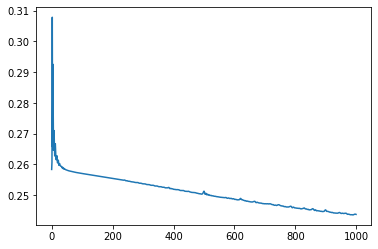

In [ ]:
plt.plot(total_loss_list_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


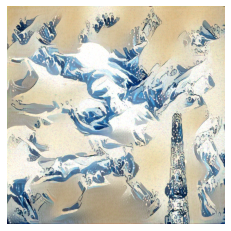

In [ ]:
fig = plt.figure()
plt.imshow(G4.cpu().data)
plt.axis('off')
fig.savefig('Tower_Water.png')

(512, 512, 3)


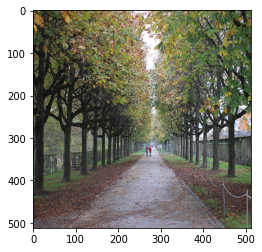

In [ ]:
import cv2
img = cv2.imread('./IMG_1368.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
plt.imshow(img)
print (img.shape)
contentImage3 = torch.tensor(img/255).float().cuda()

In [ ]:
# Content Image Convolutions
imgInput3 = torch.transpose(contentImage3.unsqueeze(0),1,3)
aCs4=[]
for l,isConv in layers_ReLU:
  imgInput3 = l(imgInput3)
  if isConv:
    aCs4.append(imgInput3)

(512, 512, 3)


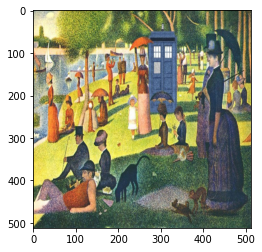

In [ ]:
import cv2
img2 = cv2.imread('./Sunday.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (512,512))
plt.imshow(img2)
print (img2.shape)
styleImage3 = torch.tensor(img2/255.0).float().cuda()

In [ ]:
# Style Image Convolutions
styleinput3 = torch.transpose(styleImage3.unsqueeze(0),1,3)
aSs4 = [] 
for l, isConv in layers_ReLU:
  styleinput3 = l(styleinput3)
  if isConv:
    aSs4.append(styleinput3)

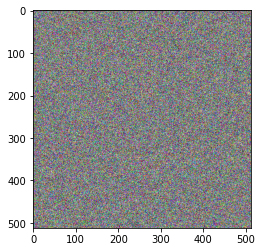

In [ ]:
G5 = torch.rand(contentImage3.shape, requires_grad=True, device="cuda")
plt.imshow(G5.cpu().data)
plt.show()

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G5],lr=1e-3)
#optimizer = optim.LBFGS([G],lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)


alpha = 1e3
beta = 1e5
total_loss_list_1 = []
epochs = 1500
i = 4
learningrate = []

for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_3 = torch.transpose(G5.unsqueeze(0),1,3)
  aG5s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_3 = l(imgInput_final_3)
    if isConv:
      aG5s.append(imgInput_final_3) 
  content_loss = compute_content_cost(aCs4[i], aG5s[i])
  style_loss = compute_style_cost(aSs4, aG5s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))

Loss at 0 iteration is 1.573798
Loss at 100 iteration is 0.332419
Loss at 200 iteration is 0.253031
Loss at 300 iteration is 0.226500
Loss at 400 iteration is 0.212638
Loss at 500 iteration is 0.203924
Loss at 600 iteration is 0.197769
Loss at 700 iteration is 0.193131
Loss at 800 iteration is 0.189626
Loss at 900 iteration is 0.186733
Loss at 1000 iteration is 0.184462
Loss at 1100 iteration is 0.184071
Loss at 1200 iteration is 0.183838
Loss at 1300 iteration is 0.183595
Loss at 1400 iteration is 0.183342


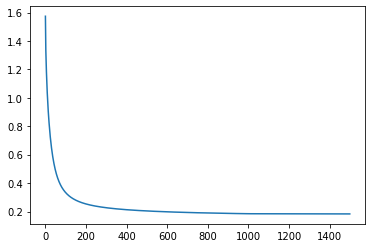

In [ ]:
plt.plot(total_loss_list_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


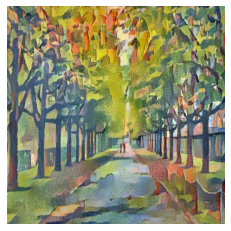

In [ ]:
fig = plt.figure()
plt.imshow(G5.cpu().data)
plt.axis('off')
fig.savefig('./Park_Afternoon.png')

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving nyc-world-trade-center-skyline-l.jpg to nyc-world-trade-center-skyline-l.jpg


(600, 800, 3)


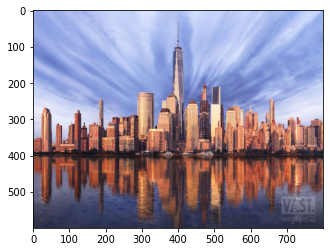

In [ ]:
import cv2
img = cv2.imread('./nyc-world-trade-center-skyline-l.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (800,600))
plt.imshow(img)
print (img.shape)
contentImage4 = torch.tensor(img/255).float().cuda()

In [ ]:
# Content Image Convolutions
imgInput4 = torch.transpose(contentImage4.unsqueeze(0),1,3)
aCs5=[]
for l,isConv in layers_ReLU:
  imgInput4 = l(imgInput4)
  if isConv:
    aCs5.append(imgInput4)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Vincent_Willem_van_Gogh_076.jpg to Vincent_Willem_van_Gogh_076.jpg


(600, 800, 3)


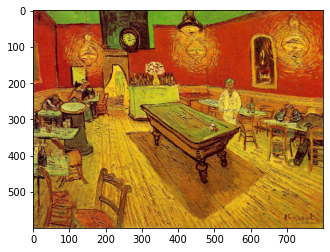

In [ ]:
import cv2
img2 = cv2.imread('./Vincent_Willem_van_Gogh_076.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (800,600))
plt.imshow(img2)
print (img2.shape)
styleImage4 = torch.tensor(img2/255.0).float().cuda()

In [ ]:
# Style Image Convolutions
styleinput4 = torch.transpose(styleImage4.unsqueeze(0),1,3)
aSs5 = [] 
for l, isConv in layers_ReLU:
  styleinput4 = l(styleinput4)
  if isConv:
    aSs5.append(styleinput4)

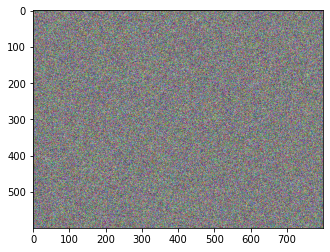

In [ ]:
torch.manual_seed(0)
G6 = torch.rand(contentImage4.shape, requires_grad=True, device="cuda")
plt.imshow(G6.cpu().data)
plt.show()

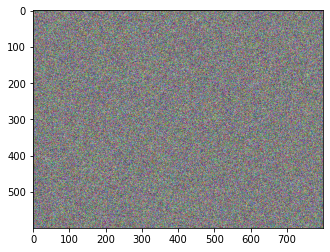

In [ ]:
torch.manual_seed(0)
G7 = torch.rand(contentImage4.shape, requires_grad=True, device="cuda")
plt.imshow(G7.cpu().data)
plt.show()

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.AdamW([G6],lr=1e-5)
#optimizer = optim.LBFGS([G],lr=1e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)


alpha = 1e3
beta = 1e3
total_loss_list_1 = []
epochs = 1000
i = 4
learningrate = []


for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_4 = torch.transpose(G6.unsqueeze(0),1,3)
  aG6s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_4 = l(imgInput_final_4)
    if isConv:
      aG6s.append(imgInput_final_4) 
  content_loss = compute_content_cost(aCs5[i], aG6s[i])
  style_loss = compute_style_cost(aSs5, aG6s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_1.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))


Loss at 0 iteration is 0.087650
Loss at 100 iteration is 0.087647
Loss at 200 iteration is 0.087645
Loss at 300 iteration is 0.087643
Loss at 400 iteration is 0.087641
Loss at 500 iteration is 0.087639
Loss at 600 iteration is 0.087637
Loss at 700 iteration is 0.087635
Loss at 800 iteration is 0.087633
Loss at 900 iteration is 0.087631


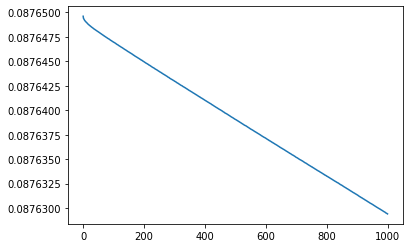

In [ ]:
plt.plot(total_loss_list_1)
loss_AdamW.append(total_loss_list_1[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 599.5, -0.5)

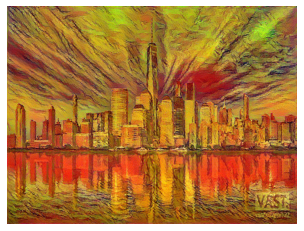

In [ ]:
fig = plt.figure()
plt.imshow(G6.cpu().data)
plt.axis('off')
fig.savefig('./NewYork_NightCafe.png')

In [ ]:
# 4th convolution layer used for the content
# 12th convolution layer used for the style 

optimizer = optim.Adam([G7],lr=1e-5)
#optimizer = optim.LBFGS([G],lr=1e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)


alpha = 1e3
beta = 1e3
total_loss_list_2 = []
epochs = 1000
i = 4
learningrate = []


for epoch in range(epochs):
  # set grads to 0
  optimizer.zero_grad()
  # compute aGs
  imgInput_final_5 = torch.transpose(G7.unsqueeze(0),1,3)
  aG7s=[]
  for l,isConv in layers_ReLU:
    imgInput_final_5 = l(imgInput_final_5)
    if isConv:
      aG7s.append(imgInput_final_5) 
  content_loss = compute_content_cost(aCs5[i], aG7s[i])
  style_loss = compute_style_cost(aSs5, aG7s, STYLE_LAYERS_WEIGHTS_1, 5)
  total_loss = alpha*content_loss + beta*style_loss
  total_loss.backward(retain_graph=True)
  for param_group in optimizer.param_groups:
    learningrate.append(param_group['lr'])
  optimizer.step()
  #scheduler.step()
  total_loss_list_2.append(total_loss.item())
  if epoch % 100 == 0:
    print('Loss at %d iteration is %f' % (epoch, total_loss.item()))


Loss at 0 iteration is 0.095780
Loss at 100 iteration is 0.095754
Loss at 200 iteration is 0.095730
Loss at 300 iteration is 0.095706
Loss at 400 iteration is 0.095682
Loss at 500 iteration is 0.095658
Loss at 600 iteration is 0.095635
Loss at 700 iteration is 0.095611
Loss at 800 iteration is 0.095587
Loss at 900 iteration is 0.095564


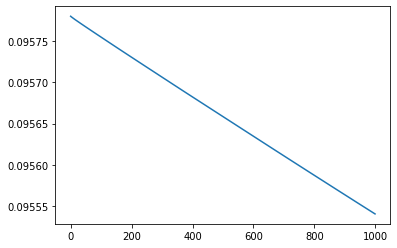

In [ ]:
plt.plot(total_loss_list_2)
loss_Adam.append(total_loss_list_2[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 799.5, 599.5, -0.5)

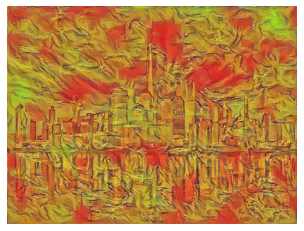

In [ ]:
fig = plt.figure()
plt.imshow(G7.cpu().data)
plt.axis('off')
fig.savefig('./NewYork_NightCafe.png')

[0.41810888051986694, 0.09910262376070023, 0.09578203409910202, 0.09554082155227661]
[0.146589457988739, 0.0883706733584404, 0.08764979988336563, 0.08762939274311066]


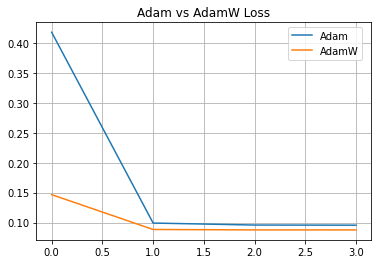

In [ ]:
print(loss_Adam)
print(loss_AdamW)
plt.plot(loss_Adam, label = "Adam")
plt.plot(loss_AdamW, label = "AdamW")
plt.grid(True)
#plt.xlim(0,30)
plt.title("Adam vs AdamW Loss")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
plt.savefig('./Adam_vs_AdamW.png')